In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import numpy as np
from pydrake.all import (
    AddDefaultVisualization,
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    LoadModelDirectives,
    LoadModelDirectivesFromString,
    Parser,
    ProcessModelDirectives,
    RigidTransform,
    RollPitchYaw,
    Simulator,
    StartMeshcat,
    FindResourceOrThrow,
    MultibodyPlant,
    MeshcatVisualizer,
    InverseDynamicsController,
    PassThrough,
    Demultiplexer,
    StateInterpolatorWithDiscreteDerivative,
    MeshcatPoseSliders,
    ConstantVectorSource,
    JointSliders,
    Multiplexer
)
import manipulation
from manipulation.station import LoadScenario, MakeHardwareStation
from manipulation.utils import ConfigureParser, RenderDiagram

import sys

sys.path.append("../")

from src.station import  MakePandaManipulationStation

In [5]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7003


# Setup Franka Panda

In [10]:
# description of robot
robot_directives = """
directives:
    - add_model:
        name: panda_arm
        file: package://drake_models/franka_description/urdf/panda_arm.urdf
        default_joint_positions:
            panda_joint1: [-1.57]
            panda_joint2: [0.1]
            panda_joint3: [0]
            panda_joint4: [-1.2]
            panda_joint5: [0]
            panda_joint6: [ 1.6]
            panda_joint7: [0]
            # panda_joint8: [0]
    - add_weld:
        parent: world
        child: panda_arm::panda_link0
    - add_model:
        name: panda_hand
        file: package://drake_models/franka_description/urdf/panda_hand.urdf
    - add_weld:
        parent: panda_arm::panda_link8
        child: panda_hand::panda_hand
        X_PC:
            translation: [0, 0, 0]
            rotation: !Rpy { deg: [0, 0, -45] }
"""

# description of objects in env
env_directives = """
directives:
    - add_model:
        name: floor
        file: package://manipulation/floor.sdf
    - add_weld:
        parent: world
        child: floor::box
        X_PC:
            translation: [0, 0, -0.05]
    - add_model:
        name: foam_brick
        file: package://manipulation/hydro/061_foam_brick.sdf
        default_free_body_pose:
            base_link:
                translation: [0.55, 0.1, 0]
"""

In [11]:
builder = DiagramBuilder()

# add panda manipulation station
# station is a system consisting of subsytems ie. multi body plant, scene graphs, controllers ... etc
station = MakePandaManipulationStation(
    robot_directives=robot_directives,
    env_directives=env_directives,
    meshcat=meshcat,
    time_step=1e-4
)

builder.AddSystem(station)

plant = station.GetSubsystemByName("plant")
panda_arm = plant.GetModelInstanceByName("panda_arm")
panda_hand = plant.GetModelInstanceByName("panda_hand")

num_panda_arm_positions = plant.num_positions(panda_arm)
num_panda_hand_positions = plant.num_positions(panda_hand)

print("num_panda_positions: ", num_panda_arm_positions)
print("num_panda_hand_positions: ", num_panda_hand_positions)


meshcat.DeleteAddedControls()

# create a joint sliders system
controller = station.GetSubsystemByName("panda_controller")
controller_plant = controller.get_multibody_plant_for_control()
joint_sliders = builder.AddSystem(JointSliders(meshcat, controller_plant))

duplex = builder.AddSystem(Demultiplexer([num_panda_arm_positions, num_panda_hand_positions]))
builder.Connect(joint_sliders.get_output_port(), duplex.get_input_port())
builder.Connect(duplex.get_output_port(0), station.GetInputPort("panda_arm.position"))
builder.Connect(duplex.get_output_port(1), station.GetInputPort("panda_hand.position"))


diagram = builder.Build()
diagram.set_name("PandaFunzo")

context = diagram.CreateDefaultContext()
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)


# get position of rigid body panda_link7
plant_context = plant.GetMyContextFromRoot(context)
panda_link7 = plant.GetBodyByName("panda_link7", panda_arm)
panda_link7_pose = plant.EvalBodyPoseInWorld(plant_context, panda_link7)
print("pose: ", panda_link7_pose)

meshcat.StartRecording()
simulator.AdvanceTo(np.inf)
meshcat.PublishRecording()

num_panda_positions:  7
num_panda_hand_positions:  2
pose:  RigidTransform(
  R=RotationMatrix([
    [0.0007607599663954592, -0.9999996829318348, 0.0002353306248870289],
    [-0.9553361862188161, -0.0007963267102639089, -0.2955201129612973],
    [0.2955202066613397, 9.525553773197387e-12, -0.955336489125606],
  ]),
  p=[0.0004345097005204591, -0.545642331171694, 0.8474039380294507],
)


KeyboardInterrupt: 

In [9]:
%tb

SystemExit: Failure at bazel-out/darwin_arm64-opt/bin/multibody/tree/_virtual_includes/multibody_tree_core/drake/multibody/tree/joint.h:466 in set_default_positions(): condition 'default_positions.size() == num_positions()' failed.

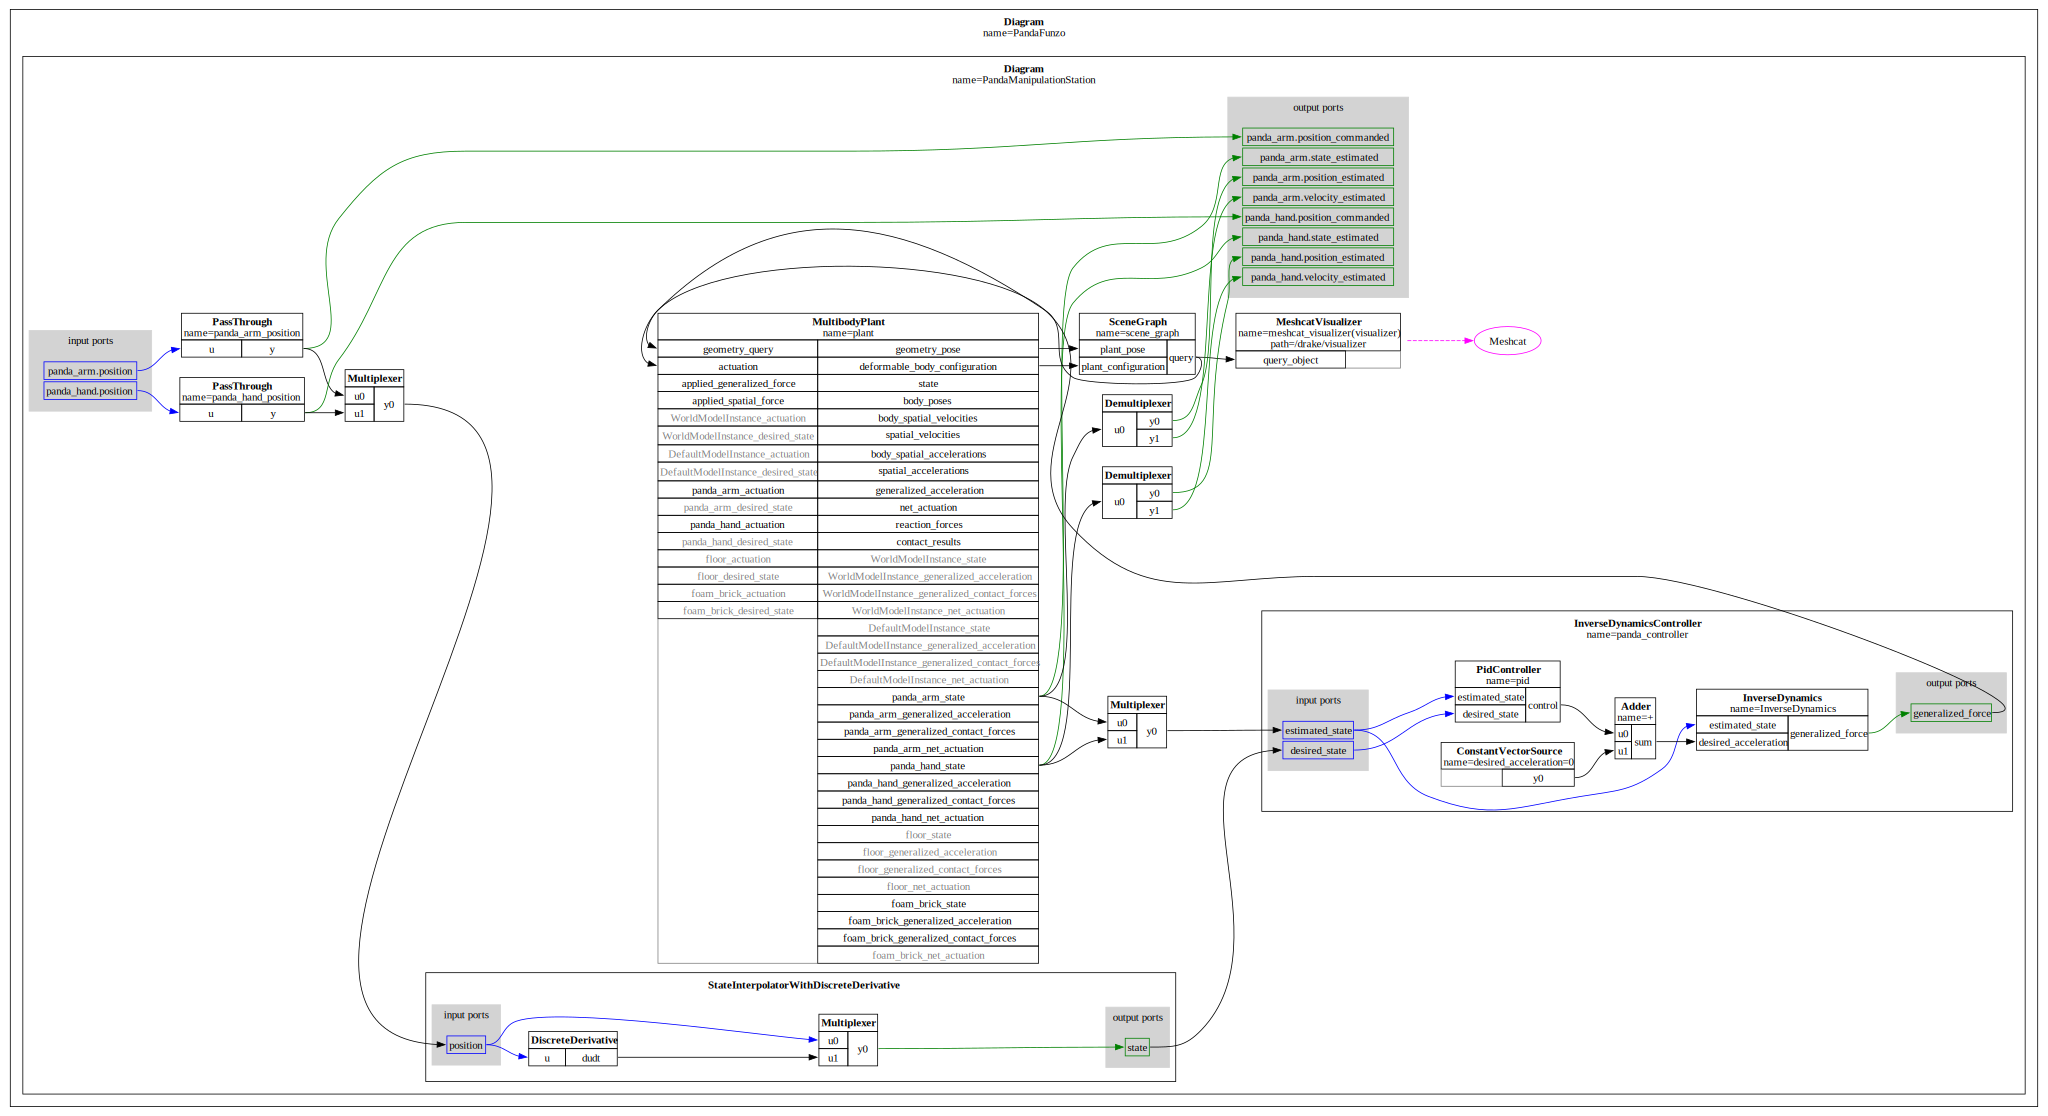

In [6]:
RenderDiagram(diagram)

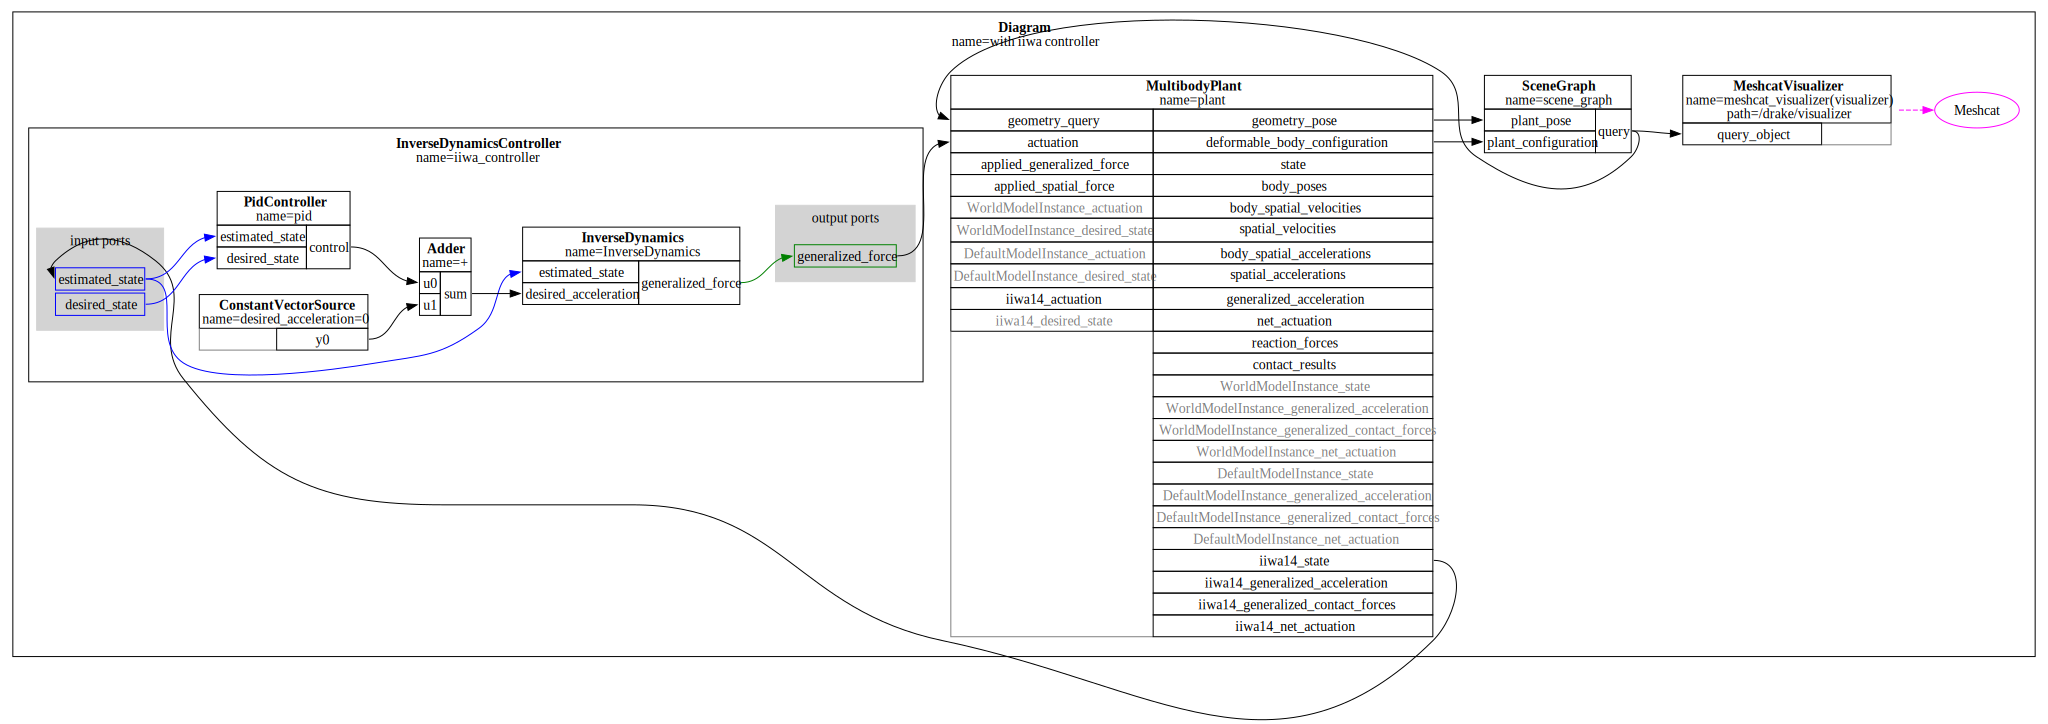

In [184]:
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# Note that we parse into both the plant and the scene_graph here.
iiwa_model = Parser(plant, scene_graph).AddModelsFromUrl(
    "package://drake_models/iiwa_description/sdf/iiwa14_no_collision.sdf"
)[0]
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

# Adds an approximation of the iiwa controller.
# TODO(russt): replace this with the joint impedance controller.
kp = [100] * plant.num_positions()
ki = [1] * plant.num_positions()
kd = [20] * plant.num_positions()
iiwa_controller = builder.AddSystem(InverseDynamicsController(plant, kp, ki, kd, False))
iiwa_controller.set_name("iiwa_controller")
builder.Connect(
    plant.get_state_output_port(iiwa_model),
    iiwa_controller.get_input_port_estimated_state(),
)
builder.Connect(
    iiwa_controller.get_output_port_control(), plant.get_actuation_input_port()
)
diagram = builder.Build()
diagram.set_name("with iiwa controller")

RenderDiagram(diagram)